This is the notebook that powered the post about weapon trade analysis.


Sources: SIPRI Extended Military Expenditure Database, Beta Version, 2016, SIPRI Arms Transfers Database, Natural Earth Vector Map


In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import operator

import community
%matplotlib inline  
import plotly
from plotly.graph_objs import *
import plotly.plotly as py
import math
import copy
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.models import ColumnDataSource,HoverTool,Label
from bokeh.palettes import Set1,Spectral,brewer,Spectral10
from decimal import Decimal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

output_notebook()
mpl.rcParams["axes.formatter.useoffset"] = False
partitioncolor = ['#5BC0EB','#D11310','#9BC53D','#E55934','#3F1427','#FA7921']

Loading BokehJS ...

# 1) Datamunging

## method to read CSV files into seperate cleaned dataframes

In [2]:
def loadTable(directory, country_code):
    path = directory+'TIV-Import-'+country_code+'-1950-2015.csv'
    df = pd.read_csv(path)
    
    #extract current country
    to_country = df.columns.values.tolist()[0].split('TIV of arms exports to ')[1].split(', 1950-2015')[0]
    
    #downsize
    df = df.ix[9:]
    
    #get rid of column
    df = df.drop(df.columns[[0]],axis =1)
    df.columns = df.iloc[0]
    df.columns.values[0] = 'country'
    df = df.set_index(df['country'])
    df = df.drop(df.columns[0], axis=1)
    
    #take the data less the header row
    df = df[1:] 
    df.index.name = None #credit to ulynn
    df.columns.name = None
    
    # Format of the keys should be YEAR - COUNTRYFROM - COUNTRYTO --> Faster query over the years

    df.columns = df.columns.astype('str').str.replace('\.0','')
    
    df.fillna(0, inplace=True)
    try:
        df.drop(df.loc['Unknown country'].name,inplace=True)
    except:
        ""
        
    #last cleansing
    df.drop(df.index[[-1,-2]],inplace=True)
    df.drop(df.columns[-1], axis=1,inplace=True)

    return df, to_country

## method from to convert dataframe to dict-in

In [3]:
#[YEARS][FROM][TO] = MONEY
def convertTableToDict(df, onecountrydict, countryTo):
    years = list(df.columns.values)
    countries = list(df.index)
    
    for year in years:
        onecountrydict.setdefault(year, dict())
        onecountrydict[year].setdefault(countryTo, dict())
        
        for country in countries:
            value = int(Decimal((df.get_value(country, year)))) # *1.81129303749 converting from 1990 to 2014
            onecountrydict[year][countryTo].setdefault(country, value)
    
    return onecountrydict

## method to clean empty or 0 values from the dicts

In [4]:
#delete empty cells from dict
def clean_empty(d):
    if not isinstance(d, (dict, list)): #dictionairy or list
        return d
    if isinstance(d, list): 
        return [v for v in (clean_empty(v) for v in d) if v] #list comprehension
    return {k: v for k, v in ((k, clean_empty(v)) for k, v in d.items()) if v}

## running the code

In [5]:
countryImportDict = dict()
PATH = '/Users/hai/Devproj/weaponstradeanalysis/data/'

countryCodeMap = dict()
for f in os.listdir(PATH):
    if not f.startswith('.'):
        if "country_codes.csv" not in f:
            countryCode = f.replace('TIV-Import-',"").replace('-1950-2015.csv', "")
            df,to_country = loadTable(PATH, countryCode)
            countryImportDict = convertTableToDict(df, countryImportDict, to_country)
            countryCodeMap.setdefault(to_country, countryCode)
            
#adding missing countrycodes
countryCodeMap['Montenegro'] = 'MNE'
countryCodeMap['Aruba'] = 'ABW'

countryImportDict = clean_empty(countryImportDict)

MultiDiDict = dict()
for year in countryImportDict:
    MultiDiDict.setdefault(year, dict())
    for countryImport in countryImportDict[year]:
        for countryExport in countryImportDict[year][countryImport]:
            MultiDiDict[year].setdefault(countryExport, dict())
            MultiDiDict[year][countryExport].setdefault(countryImport, 0)
            MultiDiDict[year][countryExport][countryImport] += countryImportDict[year][countryImport][countryExport]

In [6]:
df = pd.DataFrame.from_dict(countryCodeMap, orient="index")
df.sort_index(inplace=True)
#df.to_csv('countrymap.csv')

# 1.1) data enriching with additonal data on military expenditure

## Read table into dataframe and cleaning

In [7]:
militaryexpdf = pd.read_excel('newdata/SIPRI extended milex database beta/Constant USD Beta.xlsx')
militaryexpdf = militaryexpdf.iloc[2:175, 2:]
militaryexpdf.columns = militaryexpdf.iloc[0]
militaryexpdf.columns.values[0] = 'Country'
militaryexpdf = militaryexpdf.set_index((militaryexpdf['Country']))
militaryexpdf = militaryexpdf.drop(militaryexpdf.columns[0], axis=1)
militaryexpdf = militaryexpdf[1:] 
militaryexpdf.index.name = None #credit to ulynn
militaryexpdf.columns.name = None

namecorrectionmapping = pd.read_csv('helperfiles/countrymapping.csv', delimiter = ';', header = None)
namecorrectionmapping.columns = ['countrycode','newname', 'oldname']

namecorrectionmapping.set_index((namecorrectionmapping['oldname']), inplace = True)
namecorrectionmapping.drop(namecorrectionmapping.columns[[0,2]], axis=1, inplace = True)
namecorrectionmapping.index.name = None
namemappingdict = namecorrectionmapping.to_dict()

years = list(militaryexpdf.columns.values)
countries = list(militaryexpdf.index)
militaryexpdict = dict()
for year in years:
    militaryexpdict.setdefault(str(year), dict())
    for country in countries:
        value = militaryexpdf.get_value(country, year)
        if isinstance(value,float):
                #value = round(Decimal(value * 0.5520917815626),1) #inflation correction from constant 2014 to constant 1990
            value = round(Decimal(value),1) #inflation correction from constant 2014 to constant 1990

        militaryexpdict[str(year)].setdefault((namemappingdict['newname'][country]), value)

#militaryexpdict = convertmilitaryexpTableToDict(militaryexpdf, namemappingdict)

## Remove non-country entities from list of countries

In [8]:
excludedentities = pd.read_csv('helperfiles/excludedcountries.csv', delimiter=';', header = None)
excludedentities.columns = ['Name','Code']
excludedentitiesdict = dict()
for number in range (0,80,1):
    excludedentities.Name[number]
    #code works specifically for SIPRI data sets, who code paramilitary entities starting with 'X'
    if excludedentities.Code[number].find('X') != -1:
        excludedentitiesdict[excludedentities.Name[number]] = excludedentities.Code[number]
    #insert countries into dict
excludedentities = excludedentitiesdict.keys()
excludedentities.insert(0,'NATO**')
excludedentities.insert(0,'African Union**')
excludedentities.insert(0,'United Nations**')


In [9]:
#excludedentities

In [10]:
def clean_noncountries(d):
    if not isinstance(d, (dict)): #dictionairy or list
        return d
    return {k: v for k, v in ((k, clean_noncountries(v)) for k, v in d.items()) if k not in excludedentities}

## create a dict that returns the name of a country from the alpha-3 code 

In [11]:
isotable = pd.read_csv('helperfiles/temp_ISOalpha3_v2.csv', delimiter = ';')
isotable = isotable.dropna()
list(isotable['name'])
keys = list(isotable['alpha-3'])
values = list(isotable['name'])
alphatocountry = dict(zip(keys, values))

## Adding up two-way trade into a summed up thread

In [12]:
# most f***ed up function

def addUpDict(MasterDict):

    SomethingsOverwrittenDict = copy.deepcopy(MasterDict)

    AddedUpDict = dict()

    for year in SomethingsOverwrittenDict:
        AddedUpDict.setdefault(year, dict())
        for countryExport in SomethingsOverwrittenDict[year]:
            for countryImport in SomethingsOverwrittenDict[year][countryExport]:
                AddedUpDict[year].setdefault(countryExport, dict())
                AddedUpDict[year][countryExport].setdefault(countryImport, 0)
                Richtung = SomethingsOverwrittenDict[year][countryExport][countryImport]
                #andere richtung verfügbar?
                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        andereRichtung = SomethingsOverwrittenDict[year][countryImport][countryExport]
                    else: andereRichtung = 0
                else: andereRichtung = 0
                
                #Transmitting stuff into the AddedUpDict
                if (Richtung + andereRichtung) != 0:
                    AddedUpDict[year][countryExport][countryImport] = Richtung + andereRichtung

                #"Clearing the MasterDict"
                SomethingsOverwrittenDict[year][countryExport][countryImport] = 0

                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        SomethingsOverwrittenDict[year][countryImport][countryExport] = 0
    
    return AddedUpDict

## 1.2) Functions to create user-friendly graph data structure from dicts

In order to do sensible analysis and due to the fact that some methods (such as the clustering that is described below) only work on simple Graphs, I decided to implement both a simple as well as a digraph (= directed graph)

Clustering using the louvain method

It uses the louvain method described in Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

In [13]:
def createYearGraph(AddedUpDict, year, militaryexpdict):
    
    #adding the edges from the the dict into the graph
    G = nx.Graph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    #Louvain method(above)
    partition = community.best_partition(G)
    
    #enriching it with military expenditure data
    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military_expenditure'] = militaryexpdict[year][node]
            G.node[node]['cluster'] = partition[node]
        else:
            G.node[node]['military_expenditure'] = 'no data'
            
    G.graph['year']= year
    
    return G

In [14]:
def createYearDiGraph(AddedUpDict, year ,militaryexpdict):
    
    G = nx.DiGraph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    #temporarily also create the normal graph
    partition = community.best_partition(createYearGraph(AddedUpDict, year ,militaryexpdict))

    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military_expenditure'] = militaryexpdict[year][node]
            G.node[node]['cluster'] = partition[node]
        else:
            G.node[node]['military_expenditure'] = 'no data'
            
    G.graph['year']= year
    
    return G

In [15]:
#finally running the functions
MultiDiDict = clean_empty(clean_noncountries(MultiDiDict))
AddedUpDict = addUpDict(MultiDiDict)

year = '1960'

multigraph = createYearDiGraph(MultiDiDict, year , militaryexpdict)
mastergraph = createYearGraph(AddedUpDict, year , militaryexpdict)

## generate a dict with graphs and digraph for each year and its layout

In [16]:
def AllGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G)
        AllGraphsDict[year] = [G,layout]
    return AllGraphsDict

AllGraphs = AllGraphs(MultiDiDict, militaryexpdict)

In [17]:
def AllDiGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearDiGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G)
        AllGraphsDict[year] = [G,layout]
    return AllGraphsDict

AllDiGraphs = AllDiGraphs(MultiDiDict, militaryexpdict)

# 2.) Explorative Analysis & Visualization

## method for visualizing a simple line from a datalist

In [18]:
def displayLine(datalist,name):
    from bokeh.palettes import Spectral10
    
    plot = figure(plot_width=800, plot_height=600, tools=['pan','tap','reset','wheel_zoom','save'])

    d = dict(x=[], y=[],name=[],color=[])
    color = copy.copy(Spectral10)
    
    line = dict(xe=[], ye=[])
    for entry in sorted(datalist, key=operator.itemgetter(0)):
        d['x'].append(entry[0])
        d['y'].append(entry[1])
        d['name'].append(name)
        d['color'].append(color[0])
        line['xe'].append(entry[0])
        line['ye'].append(entry[1])
    #add legend=name for a legend
    plot.line(line['xe'], line['ye'], color=color[0])
    s1 = plot.scatter('x', 'y', line_width=1, color = color[0], source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),(name,'@y')]))
    plot.title.text=name
    
    return plot


## calculating the total weapon trade over time

In [19]:
sumedgeslist = list()

for year in AllGraphs:
    sumofedges = 0 
    for edge in AllGraphs[year][0].edges_iter(data=True):
        sumofedges = sumofedges + edge[2]['weight']
    sumedgeslist.append([year, sumofedges/1000.0])
        
sumedgeslist = sorted(sumedgeslist, key=operator.itemgetter(0))
sumedgeslist    

#line = Line(militarexpchartdict, title="line", legend="top_left", ylabel='Languages')
#show(line)

plot = displayLine(sumedgeslist,'global weapon trade in billion USD')
plot.y_range.start = 0
plot.x_range.start = 1950
plot.x_range.end = 2015

show(plot)

In [20]:
globalweapontrade = dict(year=[], value=[])
for year,value in sumedgeslist:
    globalweapontrade['year'].append(year)
    globalweapontrade['value'].append(value)
df = pd.DataFrame.from_dict(globalweapontrade).set_index('year')


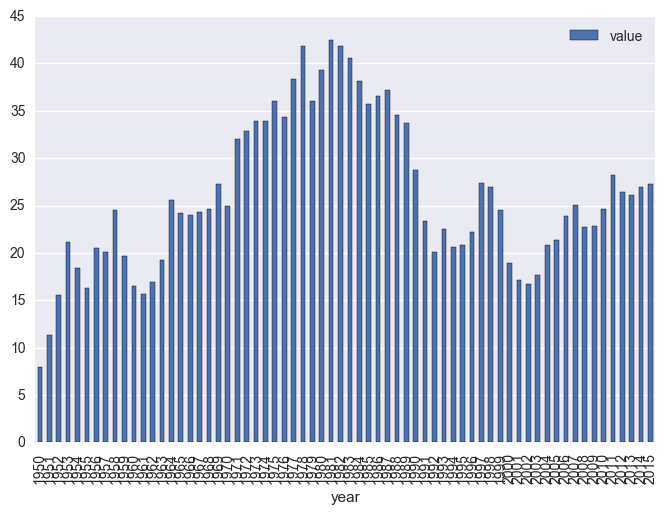

In [21]:
p = df.plot(kind='bar')
#p.set_xticks(filter(lambda x: x % 5 == 0, p.get_xticks()))
#p.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])
#p.yaxis.label = 'in billion USD'
p.xaxis.grid(False)

In [22]:
# extremely hacky code, I was frustrated. Sorry.
militarexpchartlist = list()
USAspendinglist = list()
russiaspendinglist = list()
chinaspendinglist = list()
for year in AllGraphs:
    sumofnodes = 0
    USA = 0
    russia = 0
    china = 0
    for country, value in AllGraphs[year][0].nodes_iter(data=True):
        if isinstance(value['military_expenditure'],(float,int)) and not math.isnan(value['military_expenditure']):
            if country == 'United States':
                USA = int(value['military_expenditure'])
            elif country == 'Russia':
                russia = int(value['military_expenditure'])
            elif country == 'China':
                china = int(value['military_expenditure'])
            elif country =='Soviet Union':
                pass
            else:
                sumofnodes = sumofnodes + int(value['military_expenditure'])

    militarexpchartlist.append([year, sumofnodes/1000.0])
    USAspendinglist.append([year, USA/1000.0])
    russiaspendinglist.append([year, russia/1000.0])
    chinaspendinglist.append([year, china/1000.0])

othermilex = sorted(militarexpchartlist, key=operator.itemgetter(0))
usamilex = sorted(USAspendinglist, key=operator.itemgetter(0))
russiamilex = sorted(russiaspendinglist, key=operator.itemgetter(0))
chinamilex = sorted(chinaspendinglist, key=operator.itemgetter(0))

In [23]:
# same hacky code as above.

d = dict(x=[], other_countries=[], usa=[], russia=[], china=[])
for entry in sorted(militarexpchartlist, key=operator.itemgetter(0)):
    d['x'].append(entry[0])
    d['other_countries'].append(entry[1])
    
for entry in sorted(usamilex, key=operator.itemgetter(0)):
    d['usa'].append(entry[1])
    
for entry in sorted(russiamilex, key=operator.itemgetter(0)):
    d['russia'].append(entry[1])

for entry in sorted(chinamilex, key=operator.itemgetter(0)):
    d['china'].append(entry[1])
    
df = pd.DataFrame.from_dict(d).set_index('x')

cols = ['other_countries', 'usa', 'russia', 'china']
df = df[cols]

categories = df.columns
def stacked(df, categories):
    areas = dict()
    last = np.zeros(len(df[categories[0]]))
    for cat in categories:
        next = last + df[cat]
        areas[cat] = np.hstack((last[::-1], next))
        last = next
    return areas

areas = stacked(df, categories)
colors = ['#8D99AE','#e60000','#E55934','#5BC0EB']

x2 = np.hstack((d['x'][::-1], d['x']))

p = figure(plot_width=1000, plot_height=500,x_range=(1950, 2015), y_range=(0, 1900))
p.grid.minor_grid_line_color = '#eeeeee'


for a, area in enumerate(areas):
    p.patch(x2, areas[area], color=colors[a], legend=area, alpha=0.8, line_color=None)
p.legend.location = 'top_left'
p.yaxis.axis_label = 'military expenditure in million USD'
p.xaxis.axis_label = 'year'

show(p)

In [24]:
plot = figure(plot_width=1000, plot_height=600, tools=['pan','tap','reset','wheel_zoom','save'])

d = dict(x=[], y=[],name=[],color=[])
color = copy.copy(Spectral10)

line = dict(xe=[], ye=[])
for entry in sorted(militarexpchartlist, key=operator.itemgetter(0)):
    d['x'].append(entry[0])
    d['y'].append(entry[1])
    d['name'].append('global military expenditure')
    d['color'].append(color[0])
    line['xe'].append(entry[0])
    line['ye'].append(entry[1])
#add legend=name for a legend
plot.line(line['xe'], line['ye'],legend='global military expenditure', color=color[0])
s1 = plot.scatter('x', 'y', line_width=1, color = color[0], source=ColumnDataSource(d))
plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('global military expenditure','@y')]))
plot.title.text='global military expenditure'

d = dict(x=[], y=[],name=[],color=[])
color = copy.copy(Spectral10)

line = dict(xe=[], ye=[])
for entry in sorted(USAspendinglist, key=operator.itemgetter(0)):
    d['x'].append(entry[0])
    d['y'].append(entry[1])
    d['name'].append('global weapon trade')
    d['color'].append(color[0])
    line['xe'].append(entry[0])
    line['ye'].append(entry[1])
#add legend=name for a legend
plot.line(line['xe'], line['ye'],legend='United States military expenditure',color='#5BC0EB')
s1 = plot.scatter('x', 'y', line_width=1, color = '#5BC0EB', source=ColumnDataSource(d))
plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('global weapon trade','@y')]))
plot.title.text='global military expenditure: global and US'
plot.x_range.start = 1950
plot.x_range.end = 2015
show(plot)

In [25]:
#USAspendinglist[65][1]/float(militarexpchartdict[65][1])

In [26]:
availdata = list()

for year in AllGraphs:
    dataavailable = 0.0
    datanotavailable = 0.0
    for node in AllGraphs[year][0].nodes_iter(data=True):
        if (isinstance(node[1]['military_expenditure'],(float,int)) and not math.isnan(node[1]['military_expenditure'])) or node[1]['military_expenditure'] == 'xxx':
            dataavailable+=1
        else:
            datanotavailable+=1
    
    quota = dataavailable/(dataavailable+datanotavailable)
    availdata.append([year, quota])
plot = displayLine(availdata,'data availability')
plot.y_range.start = 0
plot.x_range.start = 1950
plot.x_range.end = 2015
show(plot)

## Influence Analysis

### Definition

In [27]:
def generateTimelinesPlot(influencedict, countries, name):
    from bokeh.palettes import Spectral10
    
    plot = figure(plot_width=1000, plot_height=500, tools=['pan','tap','box_zoom','reset','wheel_zoom','save'])

    d = dict(x=[], y=[],country=[], color=[])
    color = copy.copy(partitioncolor)
    for country in countries:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[],)
        for entry in sorted(influencedict[country].items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            d['country'].append(country)
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
                    
        plot.line(line['xe'], line['ye'],legend=country, color=countrycolor)
    plot.x_range.start = 1950
    plot.x_range.end = 2015
    plot.y_range.start = 0
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('country','@country'),(name,'@y')]))
    
    return plot

In [28]:
def influenceOverTimeAll(countrydict,militaryexpdict):
    influenceAll = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year,militaryexpdict)
        for entry in nx.pagerank_numpy(G).items():
            if entry[0] in influenceAll:
                influenceAll[entry[0]][year] = entry[1]
            else:
                influenceAll.setdefault(entry[0], dict())
                influenceAll[entry[0]][year] = entry[1]
    return influenceAll

### Execution

In [29]:
influencedict = influenceOverTimeAll(MultiDiDict,militaryexpdict)

In [30]:
countriestoanalyze = ['United States', 'China', 'India', 'Soviet Union', 'Russia', 'Germany (FRG)']

plot = generateTimelinesPlot(influencedict,countriestoanalyze,'Pagerank')

plot.yaxis.bounds = [0,100]
plot.xaxis.bounds = [1950,2015]
plot.x_range.start = 1950
plot.x_range.end = 2015
plot.y_range.start = 0
#plot.y_range.end = 1
plot.xaxis.axis_label = 'year'
plot.yaxis.axis_label = 'pagerank value'
output_file('html/pagerank.html')

show(plot)

### Weapon flow over time

In [31]:
def WeaponFlowTimeAllCountries(MultiDiDict,militaryexpdict):
    weaponinflow = dict()
    weaponoutflow = dict()
    for year in MultiDiDict:
        G = createYearDiGraph(MultiDiDict, year,militaryexpdict)
        for country in G.nodes_iter():
            inflow = 0
            for x in G.in_edges_iter(nbunch=country, data=True):
                inflow = inflow + x[2]['weight']
            if country in weaponinflow:
                weaponinflow[country][year] = inflow
            else:
                weaponinflow.setdefault(country, dict())
                weaponinflow[country][year] = inflow
                
            outflow = 0
            for x in G.out_edges_iter(nbunch=country, data=True):
                outflow = outflow + x[2]['weight']
            if country in weaponoutflow:
                weaponoutflow[country][year] = outflow
            else:
                weaponoutflow.setdefault(country, dict())
                weaponoutflow[country][year] = outflow
    
    return weaponinflow, weaponoutflow

In [32]:
weaponinflow, weaponoutflow = WeaponFlowTimeAllCountries(MultiDiDict,militaryexpdict)

In [33]:
countries = ['Myanmar','United States']
plot3 = generateTimelinesPlot(weaponinflow, countries, 'Weapon Inflow')

countrystring= str()
for country in countries:
    countrystring = countrystring + country+', '
    
plot3.title.text = 'Weapon inflow into ' + countrystring

show(plot3)

In [34]:
plot3 = generateTimelinesPlot(weaponoutflow, ['United States','Germany (FRG)',  'China','Soviet Union', 'Russia'],'Weapon Outflow')

show(plot3)

# military expenditure of countries over time

In [35]:
militaryexpenditureallcountries = dict()
for year in MultiDiDict:
    G = createYearGraph(MultiDiDict, year, militaryexpdict)
    for country in G.nodes_iter(data=True):
        if country[0] in militaryexpdict:
            if isinstance(node[1]['military_expenditure'],(float,int)) and not math.isnan(node[1]['military_expenditure']):
                militaryexpenditureallcountries[country[0]][year] = country[1]['military_expenditure']
        else:
            if isinstance(node[1]['military_expenditure'],(float,int)) and not math.isnan(node[1]['military_expenditure']):
                militaryexpenditureallcountries.setdefault(country[0], dict())
                militaryexpenditureallcountries[country[0]][year] = country[1]['military_expenditure']



In [36]:
plot = generateTimelinesPlot(militaryexpenditureallcountries, ['Germany (FRG)','United States', 'Italy', 'Russia'],'Weapon Expenditure')

show(plot)

# Trade between two countries

In [37]:
def weaponflowbetweentwocountries(country1,country2,MultiDiDict):
    country1tocountry2 = dict()
    country2tocountry1 = dict()
    #totalbetweencountries = dict()
    for year in MultiDiDict:
        G = createYearDiGraph(MultiDiDict, year,militaryexpdict)
        country1tocountry2int = 0
        country2tocountry1int = 0
        #totalbetweencountriesint = 0
        for edge in G.edges_iter(nbunch=(country1,country2), data=True):
            if (edge[0] == country1) and (edge[1] == country2):
                country1tocountry2int = country1tocountry2int + edge[2]['weight']
                #totalbetweencountriesint = totalbetweencountriesint + edge[2]['weight']
            elif (edge[0] == country2) and (edge[1] == country1):                      
                country2tocountry1int = country2tocountry1int + edge[2]['weight']
                #totalbetweencountriesint = totalbetweencountriesint + edge[2]['weight']
        country1tocountry2[year] = country1tocountry2int
        country2tocountry1[year] = country2tocountry1int
        #totalbetweencountries[year] = totalbetweencountriesint
        #dicts = [country1tocountry2,country2tocountry1,totalbetweencountries]
        dicts = [country1tocountry2,country2tocountry1]

        
    plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','box_zoom','reset','wheel_zoom','save'])

    d = dict(x=[], y=[], country=[], color=[])
    color = copy.copy(Spectral10)
    for graph in dicts:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[])
        for entry in sorted(graph.items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            if graph == country1tocountry2:
                d['country'].append(country1+' to '+country2)
            elif graph == country2tocountry1:
                d['country'].append(country2+' to '+country1)
            #else:
            #    d['country'].append('totaltrade')
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
        plot.line(line['xe'], line['ye'],legend='test', color=countrycolor)
    
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('desc','@country'),('amount','@y')]))
        
    return plot


In [38]:
plot = weaponflowbetweentwocountries('India','Russia',MultiDiDict)
show(plot)

# 3.) Visualizing the weapon trade graph with Bokeh

### method to extract node data for Bokeh

In [39]:
def get_nodes_specs(_network, _layout,partition = None):
    d = dict(x=[], y=[], color=[], country=[], size=[], totaltrade =[], 
             cluster=[], alpha=[], largestpartner=[], military_expenditure=[],year=[],countrycode=[])
    
    if partition is None:
        partition = community.best_partition(_network)
    year = _network.graph['year']
    
    totaltradedict = dict()
    for exporter, importer, tradevalue in _network.edges_iter(data=True):
        if exporter in totaltradedict:
            totaltradedict[exporter] = totaltradedict[exporter] + tradevalue['weight']
        else:
            totaltradedict[exporter] = tradevalue['weight']
        if importer in totaltradedict:
            totaltradedict[importer] = totaltradedict[importer] + tradevalue['weight']
        else:
            totaltradedict[importer] = tradevalue['weight']
    maxtrade = max(totaltradedict.iteritems(), key=operator.itemgetter(1))[1]

    calc_size = lambda h: (7 + 60 * (float(h) / maxtrade))    
    
    for node in _network.nodes(data = True):
        totaltrade = 0
        largest_trade_partner_trade = 0
        largest_trade_partner_name = ''  
        
        for edge in _network.edges_iter(data=True):
                if edge[0] == node[0] or edge[1] == node[0]:
                    totaltrade += edge[2]['weight']
                    if edge[2]['weight'] >= largest_trade_partner_trade:
                        largest_trade_partner_trade = edge[2]['weight']
                        if edge[0] == node[0]:
                            largest_trade_partner_name = edge[1]
                        else:
                            largest_trade_partner_name = edge[0] 

        d['x'].append(_layout[node[0]][0])
        d['y'].append(_layout[node[0]][1])
        d['color'].append(partitioncolor[partition[node[0]]])
        d['country'].append(node[0])
        d['countrycode'].append(countryCodeMap[node[0]])

        
        if isinstance(node[1]['military_expenditure'],float) and not math.isnan(node[1]['military_expenditure']):
            #d['size'].append((np.log(node[1]['military_expenditure'])*0.8)
            d['alpha'].append(0.7)
        else:
            d['alpha'].append(0.2)
        
        if isinstance(np.log(totaltrade),(float,int)) and not math.isnan(np.log(totaltrade)):
            d['size'].append(calc_size(totaltrade))
        else:
            d['size'].append(1)

        d['totaltrade'].append(totaltrade)
        d['cluster'].append(partition[node[0]])
        
        d['largestpartner'].append(largest_trade_partner_name)
        if isinstance(node[1]['military_expenditure'],float) and not math.isnan(node[1]['military_expenditure']):
            d['military_expenditure'].append(node[1]['military_expenditure'])
        else:
            d['military_expenditure'].append('NaN')
        d['year'].append(int(year))
        
    return d

### method to extract edge data for Bokeh

In [40]:
def get_edges_specs(_network, _layout, alpha=1):
    d = dict(xs=[], ys=[], alphas=[], width=[], year=[])
    year = _network.graph['year']

    weights = []
    for u, v, data in _network.edges_iter(data=True):
        weights.append(data['weight'])
    max_weight = max(weights)
    calc_alpha = lambda h: (0.1 + 0.4 * (float(h) / max_weight))*alpha
    calc_width = lambda h: (0.7 + 10 * (float(h) / max_weight))
    for u, v, data in _network.edges_iter(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['width'].append(calc_width(data['weight']))
        d['year'].append(int(year))
    
    return d

In [41]:
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military_expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=800, plot_height=600, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

layout = nx.spring_layout(mastergraph, k = 0.3)

nodes = ColumnDataSource(get_nodes_specs(mastergraph, layout))
edges = ColumnDataSource(get_edges_specs(mastergraph, layout,1.5))

r_circles = plot.circle('x','y', source=nodes, size='size', color='color', level='overlay',alpha='alpha', name='country')
r_lines = plot.multi_line('xs', 'ys', source=edges, line_width='width', alpha='alphas', color='navy')
r_text = plot.text('x','y',source=nodes, text='country', alpha=0.9, text_font_size="7pt", text_baseline="middle", text_align="left",level='overlay')
plot.axis.visible = False
show(plot)

## Adding up graphs of the past five years

In [42]:
def combinegraphs(AllGraphs, yearstart, yearend):

    summedupgraph = nx.Graph()

    for year in range(yearstart,yearend+1,1):
        G = AllGraphs[str(year)][0]
        for edge in G.edges_iter(data=True):
            if summedupgraph.has_edge(edge[0],edge[1]):
                summedupgraph[edge[0]][edge[1]]['weight'] = summedupgraph[edge[0]][edge[1]]['weight'] + G[edge[0]][edge[1]]['weight']
            else:
                summedupgraph.add_edge(edge[0],edge[1], weight=edge[2]['weight'])

    nx.set_node_attributes(summedupgraph, 'military_expenditure', 0)
    for year in range(yearstart,yearend+1,1):
        G = AllGraphs[str(year)][0]
        for node in G.nodes(data=True):
            if isinstance(node[1]['military_expenditure'],(float,int)) and not math.isnan(node[1]['military_expenditure']):
                if 'military_expenditure' in summedupgraph.node[node[0]]:
                    summedupgraph.node[node[0]]['military_expenditure'] = summedupgraph.node[node[0]]['military_expenditure'] + G.node[node[0]]['military_expenditure']
                #else:
                #    nx.set_node_attributes(summedupgraph, 'military_expenditure', G.node[node[0]]['military_expenditure'])
    summedupgraph.graph['year'] = str(yearstart)
    return summedupgraph

summedupgraph = combinegraphs(AllGraphs,2011,2015)
    

In [43]:
def combineDigraphs(AllDiGraphs, yearstart, yearend):
    summedupDiGraph = nx.DiGraph()

    for year in range(yearstart,yearend+1,1):
        G = AllDiGraphs[str(year)][0]
        for exporter,importer,data in G.edges_iter(data=True):
            if summedupDiGraph.has_edge(exporter,importer):
                summedupDiGraph[exporter][importer]['weight'] += data['weight']
            else:
                summedupDiGraph.add_edge(exporter,importer, weight= data['weight'])

    nx.set_node_attributes(summedupDiGraph, 'military_expenditure', 0)
    for year in range(yearstart,yearend+1,1):
        G = AllDiGraphs[str(year)][0]
        for node in G.nodes(data=True):
            if isinstance(node[1]['military_expenditure'],(float,int)) and not math.isnan(node[1]['military_expenditure']):
                if 'military_expenditure' in summedupDiGraph.node[node[0]]:
                    summedupDiGraph.node[node[0]]['military_expenditure'] = summedupDiGraph.node[node[0]]['military_expenditure'] + G.node[node[0]]['military_expenditure']
                #else:
                #    nx.set_node_attributes(summedupgraph, 'military_expenditure', G.node[node[0]]['military_expenditure'])
    summedupDiGraph.graph['year'] = yearstart
    return summedupDiGraph

summedupDiGraph = combineDigraphs(AllDiGraphs,2011,2015)


In [44]:
partition = community.best_partition(summedupgraph)
induced = community.induced_graph(partition,summedupgraph)

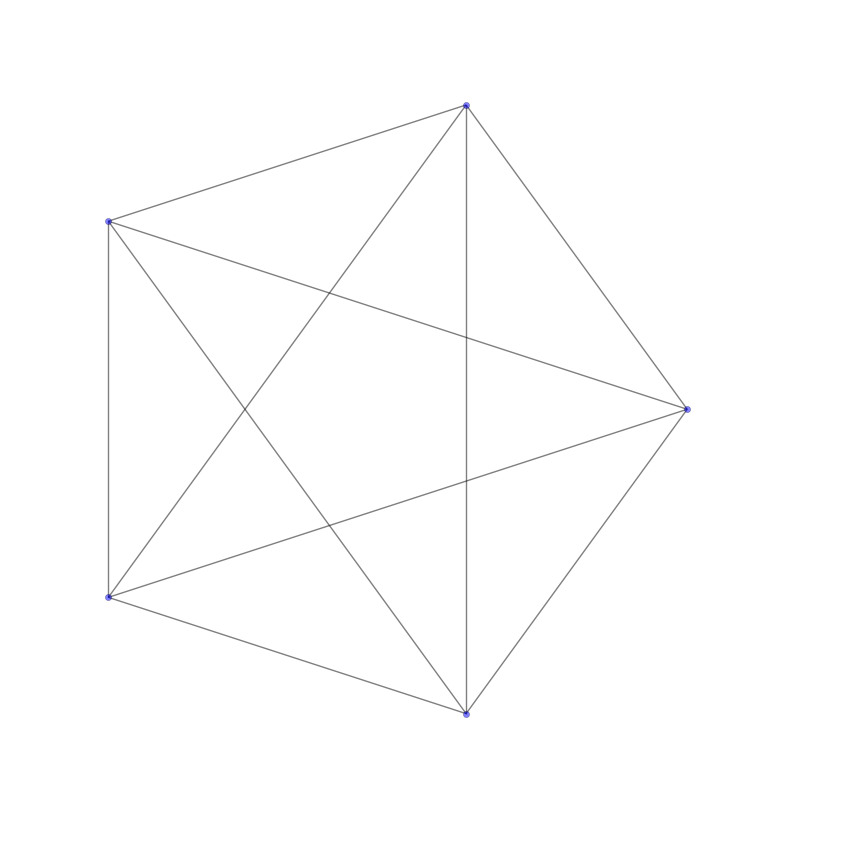

In [45]:
pos = nx.circular_layout(induced)
plt.figure(figsize=(8, 8))
nx.draw(induced, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis('equal')
plt.show()

In [46]:
induced.edge

{0: {0: {'weight': 38417},
  1: {'weight': 7533},
  2: {'weight': 17527},
  3: {'weight': 2409},
  4: {'weight': 1460}},
 1: {0: {'weight': 7533},
  1: {'weight': 29202},
  2: {'weight': 3778},
  3: {'weight': 7746},
  4: {'weight': 283}},
 2: {0: {'weight': 17527},
  1: {'weight': 3778},
  2: {'weight': 13415},
  3: {'weight': 2038},
  4: {'weight': 744}},
 3: {0: {'weight': 2409},
  1: {'weight': 7746},
  2: {'weight': 2038},
  3: {'weight': 9206},
  4: {'weight': 449}},
 4: {0: {'weight': 1460},
  1: {'weight': 283},
  2: {'weight': 744},
  3: {'weight': 449},
  4: {'weight': 778}}}

## visualize added up graph

In [47]:
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military_expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=1400, plot_height=800, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

layout = nx.spring_layout(summedupgraph, k = 0.9)

nodes = ColumnDataSource(get_nodes_specs(summedupgraph, layout))
edges = ColumnDataSource(get_edges_specs(summedupgraph, layout))

r_circles = plot.circle('x','y', source=nodes, size='size', color='color', level='overlay',alpha='alpha', name='country')
r_lines = plot.multi_line('xs', 'ys', source=edges, line_width='width', alpha='alphas', color='navy')
r_text = plot.text('x','y',source=nodes, text='country', alpha=0.9, text_font_size="8pt", text_baseline="middle", text_align="left",level='overlay')

output_file('html/graph.html')
plot.axis.visible = False
show(plot)

INFO:bokeh.core.state:Session output file 'html/graph.html' already exists, will be overwritten.


In [48]:
partition = community.best_partition(summedupgraph)

In [49]:
def bokehGraph(summedupgraph,partition=partition):
    hover = HoverTool(tooltips=[('country','@country'),
                                ('cluster','@cluster'),
                                ('military_expenditure','@military_expenditure'),
                                #('largest tradepartner', '@largestpartner'),
                                #('imports from', '@import'),
                                #('exports from', '@export')
                               ])

    plot = figure(plot_width=900, plot_height=600, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

    layout = nx.spring_layout(summedupgraph)
    
    nodes = ColumnDataSource(get_nodes_specs(summedupgraph, layout, partition))
    edges = ColumnDataSource(get_edges_specs(summedupgraph, layout))

    r_circles = plot.circle('x','y', source=nodes, size='size', color='color', level='overlay',alpha='alpha', name='country')
    r_lines = plot.multi_line('xs', 'ys', source=edges, line_width='width', alpha='alphas', color='navy')
    r_text = plot.text('x','y',source=nodes, text='country', alpha=0.9, text_font_size="8pt", text_baseline="middle", text_align="left",level='overlay')
    plot.axis.visible = False
    
    show(plot)

In [50]:
def createExportGraph(G, country,country2=None):
    
    newGraph = nx.Graph()
    newGraph.graph['year'] = G.graph['year']
    
    for edge in G.edges_iter(data=True):
        if edge[0] == country:
            newGraph.add_edge(edge[0],edge[1],edge[2])
    
    if country2:        
        for edge in G.edges_iter(data=True):
            if edge[0] == country2:
                newGraph.add_edge(edge[0],edge[1],edge[2])
    
    for node in G.nodes_iter(data=True):
        if newGraph.has_node(node[0]):
            newGraph.node[node[0]] = G.node[node[0]]
    
    return newGraph

p = createExportGraph(summedupDiGraph, 'Germany (FRG)')
bokehGraph(p)

In [51]:
p = createExportGraph(summedupDiGraph, 'Russia', 'United States')
output_file('html/russiavsUS.html')

bokehGraph(p)

INFO:bokeh.core.state:Session output file 'html/russiavsUS.html' already exists, will be overwritten.


In [52]:
p = createExportGraph(summedupDiGraph, 'United States')

bokehGraph(p)

In [53]:
def createImportGraph(G, node):
    
    newGraph = nx.Graph()
    newGraph.graph['year'] = G.graph['year']
    
    for edge in G.edges_iter(data=True):
        if edge[1] == node:
            newGraph.add_edge(edge[0],edge[1],edge[2])
    
    for node in G.nodes_iter(data=True):
        if newGraph.has_node(node[0]):
            newGraph.node[node[0]] = G.node[node[0]]
    
    return newGraph

p = createImportGraph(summedupDiGraph, 'Singapore')

bokehGraph(p)

In [54]:
#past 5 years
weaptrade5 = sorted(sumedgeslist, key=operator.itemgetter(0), reverse=True)[:5]
totaltrade5years = 0 
for year,value in weaptrade5:
    totaltrade5years += value
totaltrade5years = totaltrade5years * 1000
totaltrade5years = float(Decimal(round(totaltrade5years,1)))


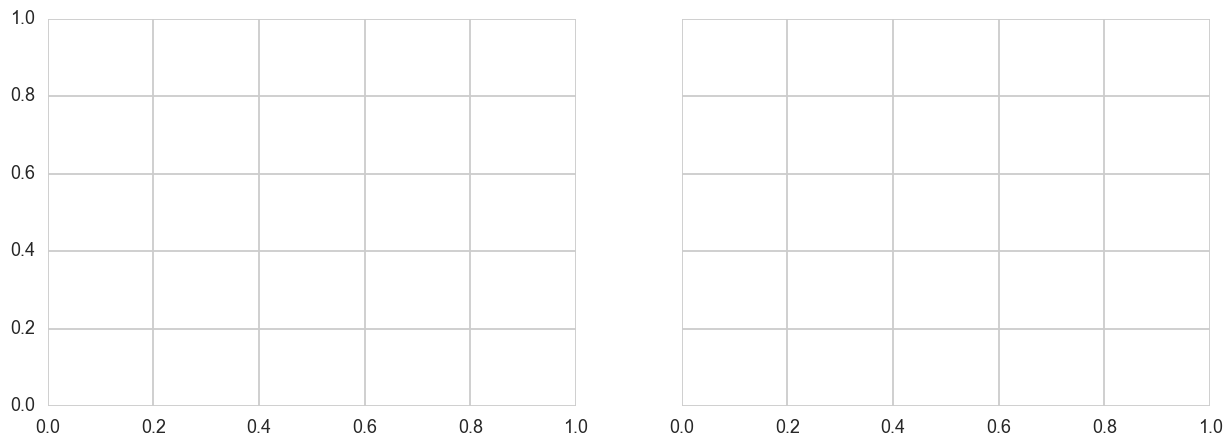

In [55]:
#from bokeh.palettes import Spectral,Set1
sns.set_style("whitegrid")
sns.set_context('talk')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

In [56]:
partition = community.best_partition(summedupgraph)

In [ ]:
weaponexport = dict()

for country in summedupDiGraph.nodes_iter():
    weaponexport[country] = 0
    for out_edges in summedupDiGraph.out_edges_iter(nbunch = country,data=True):
        weaponexport[country] = weaponexport[country] + out_edges[2]['weight']

xlist = list()
ylist = list()
huelist = list()
for x,y in  sorted(weaponexport.items(), key=operator.itemgetter(1), reverse=True)[:15]:
    #xlist.append(countryCodeMap[x])
    xlist.append(x)
    ylist.append(y/totaltrade5years)
    huelist.append(partitioncolor[partition[x]])

barvalues = pd.DataFrame.from_items([('country', xlist), ('share of global weapon trade', ylist)])

top10exporter = sns.barplot(x = 'country', y = 'share of global weapon trade',data = barvalues, palette=huelist,ax = ax1)

top10exporter.set(xlabel='',ylabel='share of global weapon trade')
top10exporter.set_title('top exporters, 2011 - 2015')
top10exporter.set_xticklabels(xlist,rotation=50)
for tick in ax1.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")


In [ ]:
weaponimport = dict()

for country in summedupDiGraph.nodes_iter():
    weaponimport[country] = 0
    for inedge in summedupDiGraph.in_edges_iter(nbunch = country, data=True):
        weaponimport[country] = weaponimport[country] + inedge[2]['weight']
        
xlistimport = list()
ylistimport = list()
huelistimport = list()
for x,y in  sorted(weaponimport.items(), key=operator.itemgetter(1), reverse=True)[:15]:
    xlistimport.append(x)
    ylistimport.append(y/totaltrade5years)
    huelistimport.append(partitioncolor[partition[x]])

barvaluesimport = pd.DataFrame.from_items([('country', xlistimport), ('share of global weapon trade', ylistimport)])

top10importer = sns.barplot(x = 'country', y = 'share of global weapon trade',data = barvaluesimport, palette=huelistimport,ax = ax2)

top10importer.set(xlabel='',ylabel='')
top10importer.set_title('top importers, 2011 - 2015')
top10importer.set_xticklabels(xlistimport,rotation=50)
for tick in ax2.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")

In [ ]:
f

In [ ]:
#data = pd.DataFrame(sorted(nx.betweenness_centrality(multigraph).items(), key=operator.itemgetter(1), reverse=True)[:10])
#data.columns = ['country','betweenness centrality']
xlist = list()
ylist = list()
huelist = list()
for x,y in sorted(nx.betweenness_centrality(summedupgraph).items(), key=operator.itemgetter(1), reverse=True)[:25]:
    xlist.append(x)
    ylist.append(y)
    huelist.append(partitioncolor[partition[x]])
    
xlist.reverse()
ylist.reverse()
huelist.reverse()
barvalues = pd.DataFrame.from_items([('country', xlist), ('betweenness centrality', ylist)])

top10centrality = barvalues.plot("country", "betweenness centrality", kind="barh", color=huelist, legend=False)
top10centrality.set(xlabel='betweenness centrality')
top10centrality.set_title('top 25 betweenness centrality')
top10centrality.set_yticklabels(xlist);


In [ ]:
colormap = Set1[9]
partition = community.best_partition(summedupgraph)
pos3=nx.spring_layout(summedupgraph, dim=3)
trace1 = []
for edge in summedupgraph.edges_iter(data=True):

    weights = list()
    for u, v, data in summedupgraph.edges_iter(data=True):
        weights.append(data['weight'])
    max_weight = max(weights)
    
    calc_alpha = lambda h: (0.4 + 0.2 * (float(h) / max_weight))
    calc_width = lambda h: (2 + 10 * (float(h) / max_weight))
    
    trace1.append(
        Scatter3d(x=[pos3[edge[0]][0],pos3[edge[1]][0], None],
                  y=[pos3[edge[0]][1],pos3[edge[1]][1], None],
                   z=[pos3[edge[0]][2],pos3[edge[1]][2], None],
                   mode='lines',
                   line=Line(color='rgb(125,125,125)',
                             width=calc_width(edge[2]['weight']),
                             colorscale = 'Bluered'),
                   hoverinfo='none',
                   opacity=calc_alpha(edge[2]['weight'])
                  
                   )
        )

totaltradedict = dict()
for exporter, importer, tradevalue in summedupgraph.edges_iter(data=True):
    if exporter in totaltradedict:
        totaltradedict[exporter] = totaltradedict[exporter] + tradevalue['weight']
    else:
        totaltradedict[exporter] = tradevalue['weight']
    if importer in totaltradedict:
        totaltradedict[importer] = totaltradedict[importer] + tradevalue['weight']
    else:
        totaltradedict[importer] = tradevalue['weight']
maxtrade = max(totaltradedict.iteritems(), key=operator.itemgetter(1))[1]

calc_size = lambda h: (3 + 40 * (float(h) / maxtrade))    


trace2 = []
for node in summedupgraph.nodes_iter():
    totaltrade = 0
    for edge in summedupgraph.edges_iter(data=True):
        if edge[0] == node or edge[1] == node:
            totaltrade += edge[2]['weight']
    
    
    trace2.append(
        Scatter3d(x=pos3[node][0],
                  y=pos3[node][1],
                   z=pos3[node][2],
                   mode='markers',
                   name='Country',
                   marker=Marker(symbol='dot',
                                 size=calc_size(totaltrade),
                                 color=colormap[partition[node]],
                                 showscale=False,
                                 cmin = 0,
                                 cmax = 4,
                                    # colorscale options
                                    # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
                                    # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
                                 colorscale='Electric',
                                 line=Line(color='rgb(50,50,50)', width=0.5)                                 ),
                   text=node,
                   hoverinfo='text',
                   opacity=0.7
                   )
        )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )
          
layout = Layout(
         title="Global Weapontrade",
         width=1000,
         height=1000,
         showlegend=False,
         scene=Scene(
             xaxis=XAxis(axis),
             yaxis=YAxis(axis),
             zaxis=ZAxis(axis),
        ),
    margin=Margin(
        t=100
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False,
            text="",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=Font(
                size=14
            )
            )
        ]),
)

data=Data(trace1+trace2)
fig=Figure(data=data, layout=layout)

#py.iplot(fig, filename='Weapontrade')

In [ ]:
xlist = list()
ylist = list()
huelist = list()
for x,y in sorted(nx.pagerank_numpy(summedupgraph).items(), key=operator.itemgetter(1), reverse=True)[:20]:
    xlist.append(x)
    ylist.append(y)
    huelist.append(partitioncolor[partition[x]])
    
xlist.reverse()
ylist.reverse()
huelist.reverse()
barvalues = pd.DataFrame.from_items([('country', xlist), ('pagerank', ylist)])

top10pagerank = barvalues.plot("country", "pagerank", kind="barh", color=huelist, legend=False)
top10pagerank.set(ylabel='pagerank')
top10pagerank.set_title('top 10 pagerank')
top10pagerank.set_yticklabels(xlist);

In [ ]:
mainxlist = list()
pageranklist = list()
weaponimportlist = list()
weaponexportlist = list()
#clusterlist = list()
clusterlist = ['#D90429','#8D99AE','#2B2D42']
for x,y in sorted(nx.pagerank_numpy(summedupgraph).items(), key=operator.itemgetter(1), reverse=True)[:15]:
    mainxlist.append(x)
    pageranklist.append((y))
    weaponimportlist.append(weaponimport[x]/totaltrade5years)
    weaponexportlist.append(weaponexport[x]/totaltrade5years)
    #clusterlist.append(partitioncolor[partition[x]])
    
mainxlist.reverse()
pageranklist.reverse()
clusterlist.reverse()
weaponexportlist.reverse()
weaponimportlist.reverse()
sns.set_style("whitegrid")

barvalues = pd.DataFrame.from_items([('country', mainxlist), ('weaponexport as share of global trade', weaponexportlist), ('weaponimport as share of global trade', weaponimportlist),('pagerank value', pageranklist), ])

#top10pagerank = sns.barplot(x = 'country', y = 'betweenness centrality',data = barvalues, palette=huelist)
top10pagerank = barvalues.plot(kind="barh", color=clusterlist, legend=True) #"country", "pagerank",
top10pagerank.set(title = 'top 15 pagerank countries')
top10pagerank.set_yticklabels(mainxlist);


top10pagerank.title.set_fontsize(16)
handles, labels = top10pagerank.get_legend_handles_labels()
top10pagerank.spines['top'].set_visible(False)
top10pagerank.spines['right'].set_visible(False)
top10pagerank.spines['bottom'].set_visible(False)
top10pagerank.spines['left'].set_visible(True)
top10pagerank.yaxis.grid(False)
top10pagerank.xaxis.grid(True)
top10pagerank.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0.9, 0.27), bbox_transform=plt.gcf().transFigure)


# 4.) Creating chloropleth maps using different metrics

In [ ]:
shapefile = 'map/ne_10m_admin_0_countries'

mpl.style.use('bmh')
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
#fig.suptitle('clusters of the world through the lens of weapontrade', fontsize=25, y=.93)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='white', linewidth=.5)

m.readshapefile(shapefile, 'units', color='#444444', linewidth=0)
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    try:
        color = partitioncolor[partition[alphatocountry[iso3]]]
    except:
        color = '#666666'

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

graticule_width = 20

parallels = np.arange(-90, 91, graticule_width)
meridians = np.arange(-180., 181., graticule_width)
dashes = [2, 9] 

# The color of the graticule lines
graticule_color = 'grey'

m.drawparallels(parallels, 
                dashes=dashes, 
                color=graticule_color)

m.drawmeridians(meridians, 
                dashes=dashes, 
                color=graticule_color)
ax.set_title('the six communities of countries based on weapon trade')

plt.show()

In [ ]:
listofmapcountries=list()
for info in m.units_info:
    if info['ADM0_A3'] not in listofmapcountries:
        listofmapcountries.append(info['ADM0_A3'])

In [ ]:
weaponexport = dict()
for country in summedupDiGraph.nodes_iter():
    weaponexport[country] = 0
    for in_edge in summedupDiGraph.out_edges_iter(nbunch = country,data=True):
        weaponexport[country] = weaponexport[country] + in_edge[2]['weight']

listofexports = list()
for countrycode in listofmapcountries:
    try:
        listofexports.append(weaponexport[alphatocountry[countrycode]])
    except:
        listofexports.append(np.NaN)

dfexport = pd.DataFrame.from_items([('export', listofexports)])
dfexport.index = listofmapcountries
dfexport.dropna(inplace=True)

In [ ]:
class ColdMapper(plt.cm.ScalarMappable):
    def __init__(self, data=None):
        #norm = plt.Normalize(vmin=0, vmax=max(data)+5000)
        norm = mpl.colors.LogNorm(vmin=100, vmax=data.max())
        cmap = plt.cm.YlGnBu
        super(ColdMapper, self).__init__(norm, cmap)
        
    def __call__(self, value):
        return self.to_rgba(value)


In [ ]:
shapefile = 'map/ne_10m_admin_0_countries'
colormap = ColdMapper((dfexport['export']+1))

fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w',linewidth=0.5)
m.readshapefile(shapefile, 'units', color='#444444', linewidth=0.1)
m.drawparallels(parallels, 
                dashes=dashes, 
                color=graticule_color)

m.drawmeridians(meridians, 
                dashes=dashes, 
                color=graticule_color)

for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in dfexport.index:
        color = '#666666'
    else:
        color = colormap(dfexport.ix[iso3]['export'])

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

# Cover up Antarctica in order to make space for the legend
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)

cb = mpl.colorbar.ColorbarBase(ax_legend,label='weapon export in million USD, 2011 - 2015', cmap=plt.cm.YlGnBu, norm=mpl.colors.LogNorm(vmin=100, vmax=dfexport['export'].max()),ticks=[1,10,100,1000,10000, dfexport['export'].max()], orientation='horizontal', format=mpl.ticker.ScalarFormatter())
ax.set_title('world of weapon export')

plt.show()

In [ ]:
class HeatMapper(plt.cm.ScalarMappable):
    """A callable that maps cold colors to low values, and hot to high.
    """
    def __init__(self, data=None):
        #norm = plt.Normalize(vmin=-500, vmax=max(data)+5000)
        norm = mpl.colors.LogNorm(vmin=100, vmax=max(data))
        cmap = plt.cm.YlOrRd
        super(HeatMapper, self).__init__(norm, cmap)
        
    def __call__(self, value):
        return self.to_rgba(value)

In [ ]:
weaponimport = dict()
for country in summedupDiGraph.nodes_iter():
    weaponimport[country] = 0
    for in_edge in summedupDiGraph.in_edges_iter(nbunch = country,data=True):
        weaponimport[country] = weaponimport[country] + in_edge[2]['weight']

listofimport = list()
for countrycode in listofmapcountries:
    try:
        listofimport.append(weaponimport[alphatocountry[countrycode]])
    except:
        listofimport.append(np.NaN)

df = pd.DataFrame.from_items([('import', listofimport)])
df.index = listofmapcountries
df.dropna(inplace=True)

In [ ]:
shapefile = 'map/ne_10m_admin_0_countries'
num_colors = 11

values = df['import']
colormap = HeatMapper(df['import'])

fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w',linewidth=0.1)

m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

m.drawparallels(parallels, 
                dashes=dashes, 
                color=graticule_color)

m.drawmeridians(meridians, 
                dashes=dashes, 
                color=graticule_color)

for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in df.index:
        color = '#666666'
    else:
        color = colormap(df.ix[iso3]['import'])

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

# Cover up Antarctica in order to make space for the legend
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
maximum = df['import'].max()

ax.set_title('world of weapon import')

cb = mpl.colorbar.ColorbarBase(ax_legend,label='weapon import in million USD, 2011 - 2015', cmap=plt.cm.YlOrRd, norm=mpl.colors.LogNorm(vmin=100, vmax=maximum),ticks=[1,10,100,1000,10000, maximum], orientation='horizontal', format=mpl.ticker.ScalarFormatter())
